In [27]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import scipy.stats as ss

sympy.init_printing()

In [28]:
def merton_jump_paths(S0, paths, lam, sigma, mu, v, m, T, I):
    np.random.seed(42)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)
        
        X[0] = np.log(S0)
        S[0] = S0
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m,v,N))
    
            if N == 0:
                M = 0
    
            else:
                for j in range(N):
                    M = np.sum(np.log(Y))
                    
            X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z + M
            S[i] = np.exp(X[i])
        matrix[k] = S
    return matrix


# drop model

def merton_jump_to_ruin_paths(S0, paths, lam, sigma, mu, v, m, T, I):
    np.random.seed(42)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)

        X[0] = np.log(S0)
        S[0] = S0
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m,v,N))
    
            if N == 0 and X[i-1] > 0:
                X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z
                S[i] = np.exp(X[i])
            else:
                S[i] = 0
        matrix[k] = S
    return matrix

In [29]:
def merton_jump_paths1(S0, paths, lam, sigma, mu, v, m, T, I):
    size=(I,paths)
    dt = T/I 
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size), np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((mu -  sigma**2/2 -lam*(m  + v**2*0.5))*dt + sigma*np.sqrt(dt) * np.random.normal(size=size)), axis=0)
    return np.exp(geo+poi_rv)*S0

def merton_jump_to_ruin_paths1(S0, paths, lam, sigma, mu, v, m, T, I):
    size = (I, paths)
    dt = T/I
    jump_indices = np.random.poisson(lam*dt, size=size)
    ruin_indices = np.cumsum(jump_indices, axis=0) > 0  # Identify points after the jump

    # Geometric Brownian Motion component
    geo = np.cumsum((mu - sigma**2/2)*dt + sigma*np.sqrt(dt) * np.random.normal(size=size), axis=0)

    # Combine and apply the ruin effect
    stock_paths = np.exp(geo)*S0
    stock_paths[ruin_indices] = 0  # Set to zero after the jump
    return stock_paths

# LSM pricing algorithm

In [30]:
import numpy as np

def LSM(K, S, I, df, basis, deg):
    paths = len(S)
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1]  # set value at maturity equal to intrinsic value

    # Valuation by LS Method
    for t in range(I - 2, 0, -1):
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive

        if np.sum(good_paths) > 0:
            if basis == 'poly':
                rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polyval(rg, S[good_paths, t])
            elif basis == 'legendre':
                rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.legendre.legval(S[good_paths, t], rg)
            elif basis =='laguerre':
                rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
            else:  # 'hermite'
                rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.hermite.hermval(S[good_paths, t], rg)

            exercise = np.zeros(len(good_paths), dtype=bool)
            exercise[good_paths] = H[good_paths, t] > C
        else:
            # If all intrinsic values are zero, mark all as non-exercise
            exercise = np.zeros(len(good_paths), dtype=bool)

        V[exercise, t] = H[exercise, t]
        V[exercise, t + 1 :] = 0
        discount_path = ~exercise
        V[discount_path, t] = V[discount_path, t + 1] * df

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    V0_array = V[:, 1] * df
    SE = np.std(V[:, 1] * df) / np.sqrt(paths)
    return V0, V0_array, SE

In [31]:
deg = 3
basis = 'legendre'
#initial price list
S0_list = np.arange(36, 45 , 1)
K = 40

# Simulation

In [32]:
mu = 0.06
r = 0.06
T = 1
I = 250
paths = 10000
m = 0

GBM_lam = 0
GBM_sigma = 0.04
GBM_mu = r
GBM_v = 0

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

df = np.exp(-mu*T)

In [33]:
# Containers for storing matrices
GBM_matrices = {}
LN_matrices = {}
JR_matrices = {}

# Containers for storing prices
GBM_prices = []
LN_prices = []
JR_prices = []

# Containers for storing standard errors
GBM_se_values = []
LN_se_values = []
JR_se_values = []

# Sample mean and variance
GBM_mean = []
GBM_var = []
LN_mean = []
LN_var = []
JR_mean = []
JR_var = []


# Generate matrices and calculate prices for each S0 in S0_list
for S0 in S0_list:
    # Generate matrices
    GBM_matrices[S0] = merton_jump_paths(S0, paths, lam=GBM_lam, sigma=GBM_sigma, mu=GBM_mu, v=GBM_v, m=m, T=T, I=I)
    LN_matrices[S0] = merton_jump_paths(S0, paths, lam=LN_lam, sigma=LN_sigma, mu=LN_mu, v=LN_v, T=T, I=I, m=m)
    JR_matrices[S0] = merton_jump_to_ruin_paths(S0, paths, lam=JR_lam, sigma=JR_sigma, mu=JR_mu, T=T, I=I, m=m, v=0)

    # Calculate prices for each stock model
    GBM_price, GBM_V, GBM_se = LSM(K, GBM_matrices[S0], I, df, basis, deg)
    LN_price, LN_V, LN_se = LSM(K, LN_matrices[S0], I, df, basis, deg)
    JR_price, JR_V, JR_se = LSM(K, JR_matrices[S0], I, df, basis, deg)

    # Calculate sample mean and variance
    GBM_mean.append(np.mean(GBM_matrices[S0][:, -1]))
    GBM_var.append(np.var(GBM_matrices[S0][:, -1]))
    LN_mean.append(np.mean(LN_matrices[S0][:, -1]))
    LN_var.append(np.var(LN_matrices[S0][:, -1]))
    JR_mean.append(np.mean(JR_matrices[S0][:, -1]))
    JR_var.append(np.var(JR_matrices[S0][:, -1]))

    # Store the prices
    GBM_prices.append(GBM_price)
    LN_prices.append(LN_price)
    JR_prices.append(JR_price)

    # Store the standard errors
    GBM_se_values.append(GBM_se)
    LN_se_values.append(LN_se)
    JR_se_values.append(JR_se)


KeyboardInterrupt: 

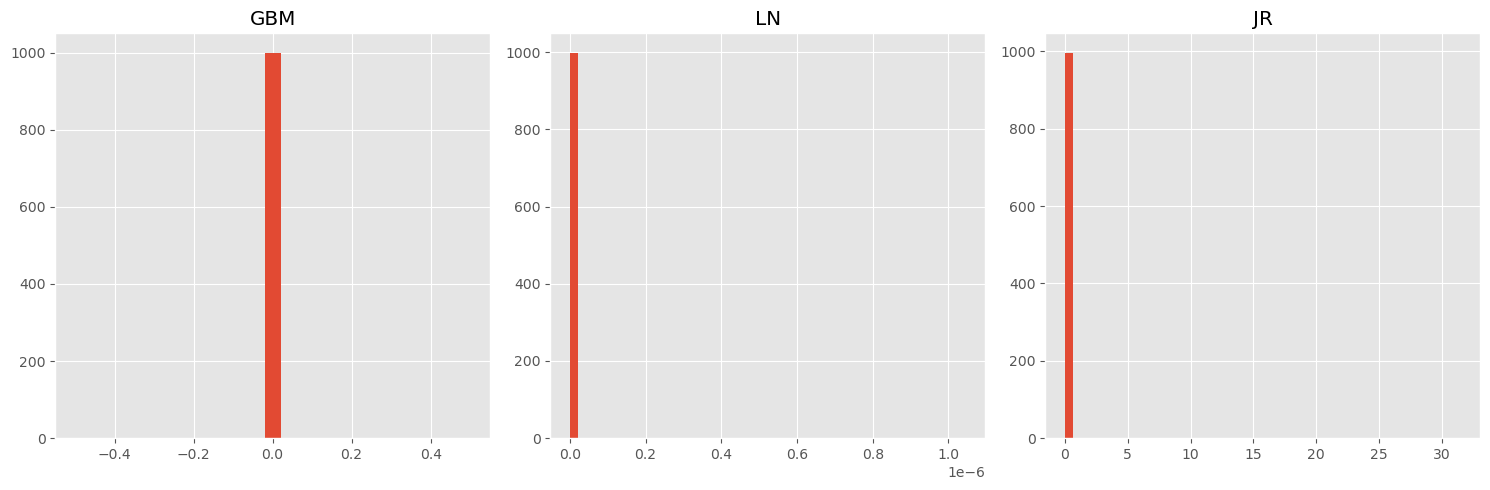

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) # Adjust the figsize as needed

axes[0].hist(GBM_V, bins=25)
axes[0].set_title('GBM')

axes[1].hist(LN_V, bins=50)
axes[1].set_title('LN')

axes[2].hist(JR_V, bins=50)
axes[2].set_title('JR')

plt.tight_layout() # This ensures that the subplots fit nicely in the figure area
plt.show()

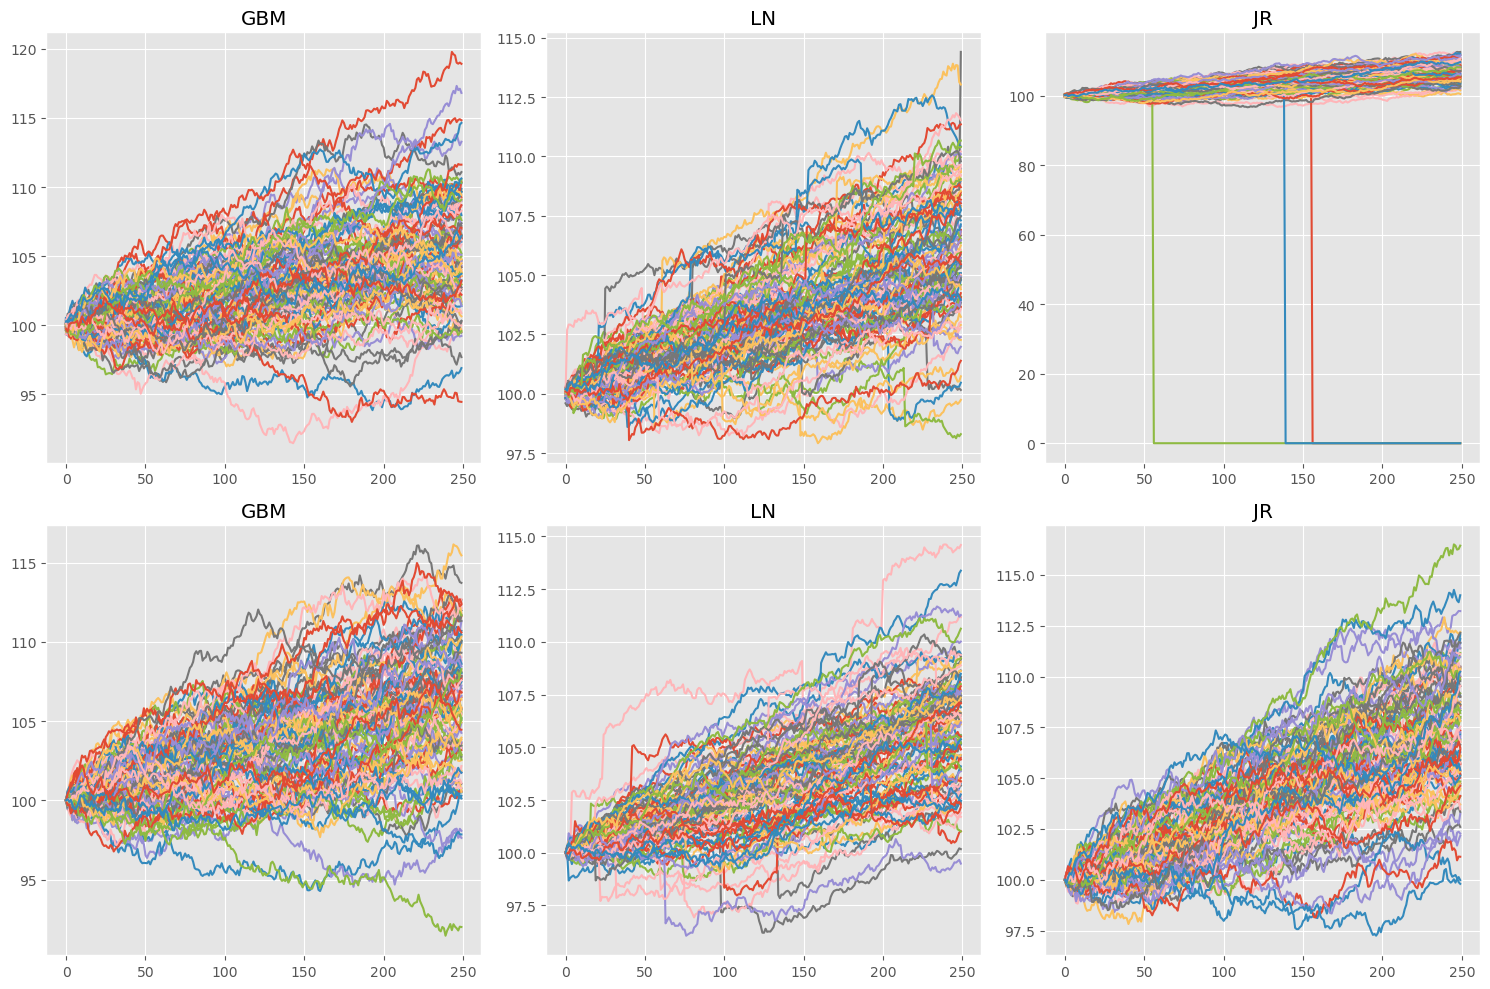

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the figsize as needed

# Plotting for the first row
axes[0, 0].plot(merton_jump_paths1(100, 100, GBM_lam, GBM_sigma, GBM_mu, GBM_v, m, 1, 250))
axes[0, 0].set_title('GBM')
axes[0, 1].plot(merton_jump_paths1(100, 100, LN_lam, LN_sigma, LN_mu, LN_v, m, 1, 250))
axes[0, 1].set_title('LN')
axes[0, 2].plot(merton_jump_to_ruin_paths1(100, 100, JR_lam, JR_sigma, JR_mu, 0, 0, 1, 250))
axes[0, 2].set_title('JR')

# Plotting for the second row
axes[1, 0].plot(merton_jump_paths(100, 100, GBM_lam, GBM_sigma, GBM_mu, GBM_v, m, 1, 250).T)
axes[1, 0].set_title('GBM')
axes[1, 1].plot(merton_jump_paths(100, 100, LN_lam, LN_sigma, LN_mu, LN_v, m, 1, 250).T)
axes[1, 1].set_title('LN')
axes[1, 2].plot(merton_jump_to_ruin_paths(100, 100, JR_lam, JR_sigma, JR_mu, 0, 0, 1, 250).T)
axes[1, 2].set_title('JR')

plt.tight_layout()  # This ensures that the subplots fit nicely in the figure area
plt.show()

In [ ]:
#print the H matrix for each model
#display_matrix(GBM_matrices[100]) 
#display_matrix(Merton_matrices[100])
#display_matrix(Drop_matrices[100])


# European Closed

In [ ]:
def closed_formula_GBM(S0, mu, sigma, T, K):
    """
    Black Scholes closed formula:
    """
    d1 = (np.log(S0 / K) + (mu + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-mu * T) * ss.norm.cdf(-d2) - S0 * ss.norm.cdf(-d1)

def closed_formula_GBM_call(S0, mu, sigma, T, K):
    """
    Black Scholes closed formula:
    """
    d1 = (np.log(S0 / K) + (mu + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * ss.norm.cdf(d1) - K * np.exp(-mu * T) * ss.norm.cdf(d2)

def closed_formula_LN(S0):
    m = LN_lam * (np.exp(LN_mu + (LN_sigma**2) / 2) - 1)
    lam2 = LN_lam * np.exp(LN_mu + LN_sigma**2) / 2
    v = LN_v

    tot = 0
    for k in range(3):
        tot += (np.exp(-lam2 * T) * (lam2 * T) ** k / np.math.factorial(k)) * closed_formula_GBM(
        S0,
        LN_mu - m + k * (LN_mu + 0.5 * LN_sigma**2) / T,
        np.sqrt(LN_sigma**2 + k * v**2 / T),
        T,
        K
        )
        return tot
    
def closed_formula_Call_JR(S0):
    return np.exp(-JR_lam * T) * closed_formula_GBM_call(S0, r, 0.04, T, K)

def closed_formula_Put_JR(S0):
    return closed_formula_Call_JR(S0) - S0 + K * np.exp(-r * T)

In [ ]:
for i, S0 in enumerate(S0_list):
    print(f"S0 = {S0}:")
    print(f"GBM_sample_mean: {GBM_mean[i]}, GBM_sample_var: {GBM_var[i]}")
    print(f"LN_sample_mean: {LN_mean[i]}, LN_sample_var: {LN_var[i]}")
    print(f"JR_sample_mean: {JR_mean[i]}, JR_sample_var: {JR_var[i]}")

S0 = 36:
GBM_sample_mean: 38.22255569745386, GBM_sample_var: 2.2994463409185215
LN_sample_mean: 38.24863764176897, LN_sample_var: 1.167755720218385
JR_sample_mean: 38.266674603047896, JR_sample_var: 14.570761490875638
S0 = 37:
GBM_sample_mean: 39.28429335571648, GBM_sample_var: 2.4289676240103812
LN_sample_mean: 39.311099798484776, LN_sample_var: 1.2335320840887107
JR_sample_mean: 39.32963778646589, JR_sample_var: 15.391491111889463
S0 = 38:
GBM_sample_mean: 40.34603101397908, GBM_sample_var: 2.56203743540613
LN_sample_mean: 40.37356195520058, LN_sample_var: 1.3011105401198673
JR_sample_mean: 40.39260096988388, JR_sample_var: 16.234706475944765
S0 = 39:
GBM_sample_mean: 41.407768672241694, GBM_sample_var: 2.6986557751057645
LN_sample_mean: 41.43602411191638, LN_sample_var: 1.3704910883118546
JR_sample_mean: 41.45556415330188, JR_sample_var: 17.100407583041545
S0 = 40:
GBM_sample_mean: 42.4695063305043, GBM_sample_var: 2.838822643109285
LN_sample_mean: 42.49848626863219, LN_sample_var: 

In [ ]:
# Print the V0 price for each model and each S0
for i, S0 in enumerate(S0_list):
    print(f"S0 = {S0}:")
    print(f"  GBM Price: {GBM_prices[i]},   se = {GBM_se_values[i]}")
    print(f"  LN Price: {LN_prices[i]},  se = {LN_se_values[i]}")
    print(f"  JR Price: {JR_prices[i]}, se = {JR_se_values[i]}")
    print(f"  European_GBM: {closed_formula_GBM(S0, GBM_mu, GBM_sigma, T, K)}")
    print(f"  European_LN: {closed_formula_LN(S0)}")
    print(f"  European_JR: {closed_formula_Put_JR(S0)}")
    print()

S0 = 36:
  GBM Price: 3.7573152516915713,   se = 0.002834072477476187
  LN Price: 3.759570969845941,  se = 0.002302770624442733
  JR Price: 3.757100110916962, se = 0.0020079380933994686
  European_GBM: 1.7650337894446295
  European_LN: 2.3999947034821814
  European_JR: 1.7640939719033923

S0 = 37:
  GBM Price: 2.8152800824782838,   se = 0.0029127967129616347
  LN Price: 2.817598459470274,  se = 0.002366736475121697
  JR Price: 2.8150589655710463, se = 0.0020637141515494556
  European_GBM: 0.9900986466691144
  European_LN: 1.8120581082563678
  European_JR: 0.9869193963812677

S0 = 38:
  GBM Price: 1.8732449132649962,   se = 0.002991520948447081
  LN Price: 1.875625949094608,  se = 0.00243070232580066
  JR Price: 1.8730178202251306, se = 0.0021194902096994418
  European_GBM: 0.4532580674049722
  European_LN: 1.2246565239473155
  European_JR: 0.44547030388016395

S0 = 39:
  GBM Price: 0.9312097440517084,   se = 0.0030702451839325316
  LN Price: 0.9340533322639998,  se = 0.0023057689783636